# Evaluating Tabular Classifications

## Introduction

In this notebook, we'll walk-through a detailed example of how you can use Valor to evaluate classifications made on a tabular dataset. This example uses `sklearn`'s breast cancer dataset to make a binary prediction about whether a woman has breast cancer, based on a table of descriptive features, such as mean radius and mean texture.

For a conceptual introduction to Valor, [check out our project overview](https://striveworks.github.io/valor/). For a higher-level example notebook, [check out our "Getting Started" notebook](https://github.com/Striveworks/valor/blob/main/examples/getting_started.ipynb).

## Defining Our Datasets

We start by fetching our dataset, dividing it into test/train splits, and uploading both sets to Valor.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

from valor_lite.classification import DataLoader, Classification, MetricType

In [2]:
# load data from sklearn
dset = load_breast_cancer()
dset.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [3]:
# split datasets
X, y, target_names = dset["data"], dset["target"], dset["target_names"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

# show an example input
X_train.shape, y_train[:4], target_names

((426, 30), array([0, 0, 0, 1]), array(['malignant', 'benign'], dtype='<U9'))

### Create GroundTruths

In [4]:
# format training groundtruths
training_groundtruths = [
    (f"train{i}", target_names[t])
    for i, t in enumerate(y_train)
]

# format testing groundtruths
testing_groundtruths = [
    (f"test{i}", target_names[t])
    for i, t in enumerate(y_test)
]

## Defining Our Model

Now that our `Datasets` have been defined, we can describe our model in Valor using the `Model` object.

In [5]:
# fit an sklearn model to our data
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)

# get predictions on both of our datasets
y_train_probs = pipe.predict_proba(X_train)
y_test_probs = pipe.predict_proba(X_test)

# show an example output
y_train_probs[:4]

array([[9.99999999e-01, 6.38279129e-10],
       [9.96481161e-01, 3.51883931e-03],
       [9.99848177e-01, 1.51822522e-04],
       [1.26504824e-03, 9.98734952e-01]])

### Create Predictions

In [6]:

# define our predictions
training_predictions = [
    (
        f"train{i}",
        [
            (target_names[j], p)
            for j, p in enumerate(prob)
        ],
    )
    for i, prob in enumerate(y_train_probs)
]
testing_predictions = [
    (
        f"test{i}",
        [
            (target_names[j], p)
            for j, p in enumerate(prob)
        ],
    )
    for i, prob in enumerate(y_test_probs)
]

## Create Classifications

In [7]:
training_clfs = [
    Classification(
        uid=gt[0],
        groundtruth=gt[1],
        predictions=[
            plabel
            for plabel, _ in pd[1]
        ],
        scores=[
            score
            for _, score in pd[1]
        ]
    )
    for gt, pd in zip(training_groundtruths, training_predictions)
    if gt[0] == pd[0]
]

testing_clfs = [
    Classification(
        uid=gt[0],
        groundtruth=gt[1],
        predictions=[
            plabel
            for plabel, _ in pd[1]
        ],
        scores=[
            score
            for _, score in pd[1]
        ]
    )
    for gt, pd in zip(testing_groundtruths, testing_predictions)
    if gt[0] == pd[0]
]

## Evaluating Performance

With our `Dataset` and `Model` defined, we're ready to evaluate our performance and display the results. Note that we use the `wait_for_completion` method since all evaluations run as background tasks; this method ensures that the evaluation finishes before we display the results.

In [8]:
training_loader = DataLoader()
training_loader.add_data(training_clfs)
training_evaluator = training_loader.finalize()

testing_loader = DataLoader()
testing_loader.add_data(testing_clfs)
testing_evaluator = testing_loader.finalize()

# Validate with sklearn

As a brief sanity check, we can check Valor's outputs against `sklearn's` own classification report.

In [9]:
y_train_preds = pipe.predict(X_train)
print(classification_report(y_train, y_train_preds, digits=6, target_names=target_names))

              precision    recall  f1-score   support

   malignant   1.000000  0.980132  0.989967       151
      benign   0.989209  1.000000  0.994575       275

    accuracy                       0.992958       426
   macro avg   0.994604  0.990066  0.992271       426
weighted avg   0.993034  0.992958  0.992942       426



In [10]:
metrics = training_evaluator.compute_metrics()

In [11]:
metrics[MetricType.Precision]

[Precision(value=[1.0], score_thresholds=[0.0], hardmax=True, label='malignant'),
 Precision(value=[0.9892086330935251], score_thresholds=[0.0], hardmax=True, label='benign')]

In [12]:
metrics[MetricType.Recall]

[Recall(value=[0.9801324503311258], score_thresholds=[0.0], hardmax=True, label='malignant'),
 Recall(value=[1.0], score_thresholds=[0.0], hardmax=True, label='benign')]

In [13]:
metrics[MetricType.F1]

[F1(value=[0.9899665551839464], score_thresholds=[0.0], hardmax=True, label='malignant'),
 F1(value=[0.9945750452079565], score_thresholds=[0.0], hardmax=True, label='benign')]

## Now, lets plot the Precision-Recall curve.

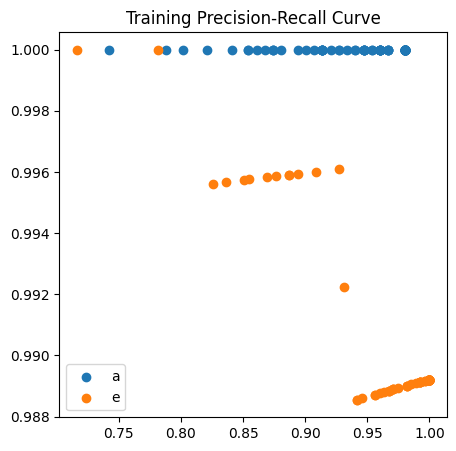

In [14]:
metrics = training_evaluator.compute_metrics(score_thresholds=[x / 100.0 for x in range(1, 100)])

precisions = metrics[MetricType.Precision]
recalls = metrics[MetricType.Recall]

plt.rcParams['figure.figsize'] = [5, 5]
plt.figure()
for r, p in zip(recalls, precisions):  
    if r.label != p.label:
        raise ValueError  
    plt.scatter(r.value, p.value, label=r.label[1])
plt.title("Training Precision-Recall Curve")
plt.legend()
plt.show()

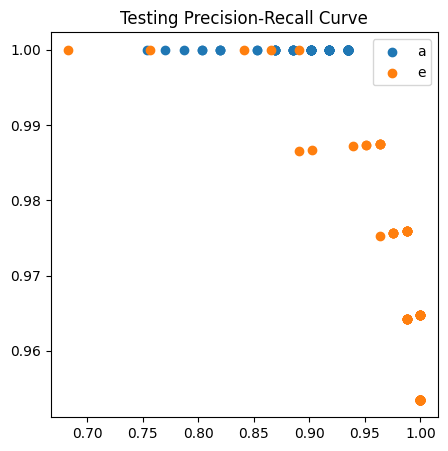

In [15]:
metrics = testing_evaluator.compute_metrics(score_thresholds=[x / 100.0 for x in range(1, 100)])

precisions = metrics[MetricType.Precision]
recalls = metrics[MetricType.Recall]

plt.rcParams['figure.figsize'] = [5, 5]
plt.figure()
for r, p in zip(recalls, precisions):
    if r.label != p.label:
        raise ValueError  
    plt.scatter(r.value, p.value, label=r.label[1])
plt.title("Testing Precision-Recall Curve")
plt.legend()
plt.show()

## Use pandas to display the confusion matrix.

In [16]:
metrics = testing_evaluator.compute_confusion_matrix(
    score_thresholds=[0.0]
)

cm = metrics[0]
pd.DataFrame(
    {
        gt: {
            pd: cm.confusion_matrix[gt][pd]["count"]
            for pd in cm.confusion_matrix[gt]
        }
        for gt in cm.confusion_matrix
    }
)


,malignant,benign
malignant,57,0
benign,4,82


In [17]:
cm.missing_predictions

{'malignant': {'count': 0, 'examples': []},
 'benign': {'count': 0, 'examples': []}}